## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

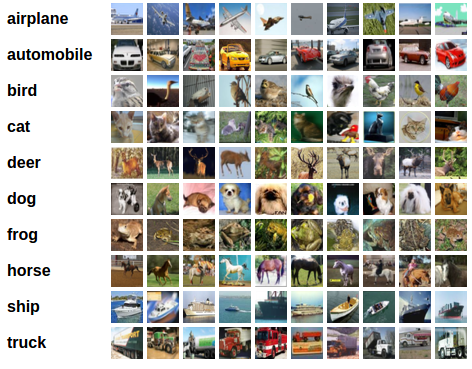

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(3407)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.

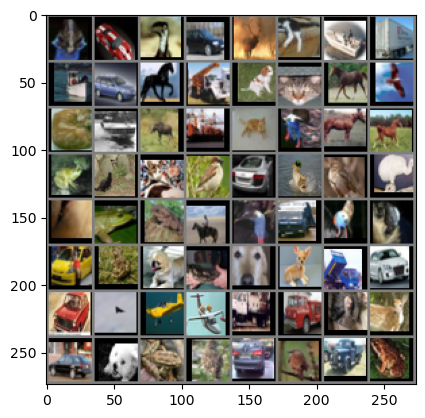

bird  car   bird  car   deer  cat   ship  truck ship  car   horse truck dog   cat   horse bird  cat   ship  deer  ship  cat   bird  horse horse frog  cat   cat   bird  car   bird  bird  bird  cat   frog  frog  horse bird  truck bird  dog   car   frog  dog   cat   dog   dog   truck car   car   plane plane plane truck truck cat   deer  car   dog   frog  bird  car   bird  truck frog 
torch.Size([64, 3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(images.size())

## 2. Define a Convolutional Neural Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
    
from vision import vit_tiny_4_32

net = vit_tiny_4_32()
model = net.to(device)

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=5e-4)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
def test(loss_vector, accuracy_vector, epoch):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('epoch {}--Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch+1, val_loss, correct, len(testloader.dataset), accuracy))

In [7]:
lossv,accv=[],[]
losst,acct=[],[]

for epoch in range(30):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losst.append(loss.item())
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    test(lossv,accv, epoch)
print('Finished Training')

[1,   100] loss: 0.104
[1,   200] loss: 0.096
[1,   300] loss: 0.093
[1,   400] loss: 0.091
[1,   500] loss: 0.088
[1,   600] loss: 0.088
[1,   700] loss: 0.086
epoch 1--Validation set: Average loss: 1.6441, Accuracy: 3924/10000 (39%)

[2,   100] loss: 0.084
[2,   200] loss: 0.083
[2,   300] loss: 0.082
[2,   400] loss: 0.081
[2,   500] loss: 0.080
[2,   600] loss: 0.080
[2,   700] loss: 0.080
epoch 2--Validation set: Average loss: 1.4899, Accuracy: 4642/10000 (46%)

[3,   100] loss: 0.078
[3,   200] loss: 0.078
[3,   300] loss: 0.077
[3,   400] loss: 0.076
[3,   500] loss: 0.075
[3,   600] loss: 0.076
[3,   700] loss: 0.076
epoch 3--Validation set: Average loss: 1.3764, Accuracy: 4953/10000 (50%)

[4,   100] loss: 0.075
[4,   200] loss: 0.073
[4,   300] loss: 0.074
[4,   400] loss: 0.074
[4,   500] loss: 0.074
[4,   600] loss: 0.073
[4,   700] loss: 0.073
epoch 4--Validation set: Average loss: 1.3811, Accuracy: 5106/10000 (51%)

[5,   100] loss: 0.072
[5,   200] loss: 0.072
[5,   300]

Let’s quickly save our trained model:

In [8]:
PATH = './cifar_vit.pth'
torch.save(net.state_dict(), PATH)

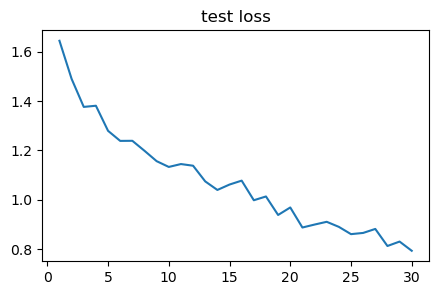

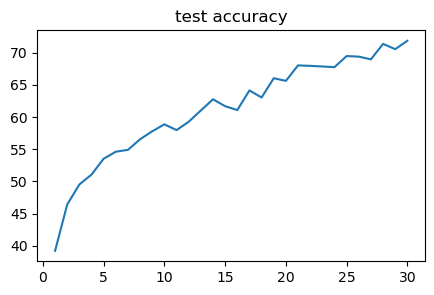

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,31), lossv)
plt.title('test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,31), accv)
plt.title('test accuracy');

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

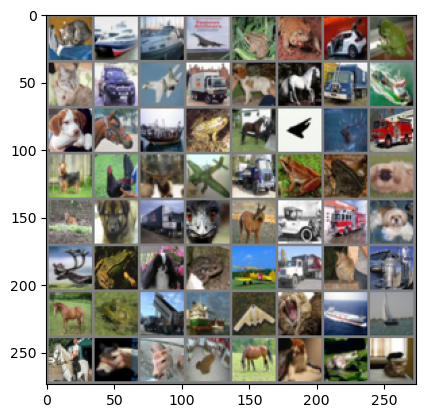

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [11]:
net = vit_tiny_4_32()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [12]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 68.35 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 66.3 %
Accuracy for class: car   is 73.0 %
Accuracy for class: bird  is 48.2 %
Accuracy for class: cat   is 41.8 %
Accuracy for class: deer  is 75.3 %
Accuracy for class: dog   is 68.0 %
Accuracy for class: frog  is 74.2 %
Accuracy for class: horse is 69.6 %
Accuracy for class: ship  is 83.5 %
Accuracy for class: truck is 79.8 %
